# 1. Intro

이번 노트에서는 MNIST 손글씨 데이터를 선형 모델로 분류하면서, 학습 방식에 따라 성능이 어떻게 달라지는지를 실험합니다. 구체적으로는 Batch Gradient Descent, Stochastic Gradient Descent(SGD), Mini-Batch Gradient Descent 세 가지 최적화 방식을 비교해볼 예정입니다. 다만, MNIST의 훈련 데이터는 총 60,000개로, Batch Gradient Descent를 엄밀하게 구현하려면 동일한 크기의 배치를 사용해야 합니다. 그러나 이 경우 메모리 과부하가 발생할 수 있어, 실험을 간소화하여 각각 배치 크기를 1024, 32, 1로 설정한 세 가지 케이스로 대체하여 실험을 진행할 예정입니다. 분류 문제이므로 손실 함수는 CrossEntropy Loss를 사용하고, 동일한 모델 구조와 하이퍼파라미터 조건 하에서 학습 방식만 달리하여 그 차이를 분석할 계획입니다.

## 1.1 HypereParameter

In [1]:
import torch

random_state = 42
device = "cuda" if torch.cuda.is_available else "cpu"

n_dim = 1024
lr = 1e-3

## 1.2 Load Dataset

In [2]:
from sklearn.model_selection import train_test_split
import torchvision

# train nums: 60000, val nums: 8000, val nums: 2000

trainset = torchvision.datasets.MNIST(
    root='../data',
    train=True,
    download=True,
)
testset = torchvision.datasets.MNIST(
    root='../data',
    train=False,
    download=True,
)

test_size= 0.2
x_train = trainset.data.view(-1, 1, 28, 28)
y_train = trainset.targets
x_test = testset.data.view(-1, 1, 28, 28)
y_test = testset.targets
x_val, x_test, y_val, y_test = train_test_split(
    x_test,
    y_test,
    test_size=test_size,
    random_state=random_state
)

print(f"Train Dataset Shape:\nx_train:{x_train.numpy().shape}, y_train:{y_train.numpy().shape[0]}", end="\n\n")
print(f"Val Dataset Shape:\nx_val:{x_val.numpy().shape}, y_val:{y_val.numpy().shape[0]}", end="\n\n")
print(f"Test Dataset Shape:\nx_test:{x_test.numpy().shape}, y_test:{y_test.numpy().shape[0]}", end="\n\n")

100%|██████████| 9.91M/9.91M [00:00<00:00, 14.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 478kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.38MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.98MB/s]

Train Dataset Shape:
x_train:(60000, 1, 28, 28), y_train:60000

Val Dataset Shape:
x_val:(8000, 1, 28, 28), y_val:8000

Test Dataset Shape:
x_test:(2000, 1, 28, 28), y_test:2000



## 1.3 Check Label Distribution

In [3]:
import pandas as pd
# No Data imbalance was found
# Output dimension of the final layer is set to 10

df = [
    pd.Series(label.numpy())
    .value_counts(normalize=True)
    .sort_index(ascending=True)
    .round(3)
        for label in [y_train, y_val, y_test]
]
df = pd.concat(df, axis=1)
df.columns = ['train', 'val', 'test']
df

,train,val,test
0,0.099,0.097,0.102
1,0.112,0.115,0.108
2,0.099,0.102,0.106
3,0.102,0.100,0.104
4,0.097,0.096,0.108
5,0.090,0.090,0.087
6,0.099,0.095,0.100
7,0.104,0.105,0.094
8,0.098,0.098,0.093
9,0.099,0.101,0.099


## 1.4 Check Label Image

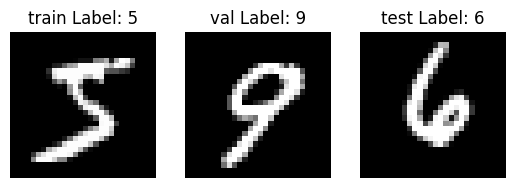

In [4]:
from matplotlib import pyplot as plt

# Images are in grayscale
def check_data(num, *args):
    for i, (sort, x, y) in enumerate(args):
        plt.subplot(1,len(args),i+1)
        plt.imshow(x[num][0], cmap='gray')
        plt.title(f"{sort} Label: {y[num]}")
        plt.axis('off')

# num: Determineing which sample to display
num=0
check_data(
    num,
    ("train", x_train, y_train),
    ("val", x_val, y_val),
    ("test", x_test, y_test)
)

## 1.5 Check X data

In [5]:
# The data is distributed in the range of 0 to 255.
# The adoption of normalization, such as dividing by 255, is recommended.
print(set(x_train[0].flatten().numpy()))

{np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(9), np.uint8(11), np.uint8(14), np.uint8(16), np.uint8(18), np.uint8(23), np.uint8(24), np.uint8(25), np.uint8(26), np.uint8(27), np.uint8(30), np.uint8(35), np.uint8(36), np.uint8(39), np.uint8(43), np.uint8(45), np.uint8(46), np.uint8(49), np.uint8(55), np.uint8(56), np.uint8(64), np.uint8(66), np.uint8(70), np.uint8(78), np.uint8(80), np.uint8(81), np.uint8(82), np.uint8(90), np.uint8(93), np.uint8(94), np.uint8(107), np.uint8(108), np.uint8(114), np.uint8(119), np.uint8(126), np.uint8(127), np.uint8(130), np.uint8(132), np.uint8(133), np.uint8(135), np.uint8(136), np.uint8(139), np.uint8(148), np.uint8(150), np.uint8(154), np.uint8(156), np.uint8(160), np.uint8(166), np.uint8(170), np.uint8(171), np.uint8(172), np.uint8(175), np.uint8(182), np.uint8(183), np.uint8(186), np.uint8(187), np.uint8(190), np.uint8(195), np.uint8(198), np.uint8(201), np.uint8(205), np.uint8(207), np.uint8(212), np.uint8(213), np.uint8(219), np.

## 1.6 Data Preprocessing with Normalization

In [6]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import numpy as np

# Using a Torch Dataset is necessary.
# It's the standard way to train Models in PyTorch
class dastaset(Dataset):
    def __init__(self, x, y, transform=None):
        torch.manual_seed(random_state)
        self.x = x
        self.y = y
        self.transform = transform

    def __getitem__(self, idx):
        sample_x, sample_y = self.x[idx], self.y[idx]
        if self.transform:
            sample_x = self.transform(sample_x)
        return sample_x, sample_y

    def __len__(self):
        return len(self.x)

# Normalization should be based only on the training data to avoid data leakage.
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.to(dtype=torch.float)),
    transforms.Normalize((x_train.float().mean() / 255.0,), (x_train.float().std() / 255.0,)),
])

dataset_dict = {name:dastaset(x,y,transform)
                    for name,x,y in [
                            ('train', x_train, y_train),
                            ('val', x_val, y_val),
                            ('test', x_test, y_test)
                        ]
                }
print(f"Dataset Keys: {dataset_dict.keys()}", end='\n\n')
for name in dataset_dict.keys():
    print(f"{name} len: {len(dataset_dict[name])}", end='\n\n')

# Normalization is applied properly
print(dataset_dict['train'][0][0].flatten()[:10])

Dataset Keys: dict_keys(['train', 'val', 'test'])

train len: 60000

val len: 8000

test len: 2000

tensor([-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
        -0.4241, -0.4241])


### 참고: Data Leakage

데이터 정규화(normalization 또는 standardization)를 수행할 때는 반드시 **훈련 데이터(train set)**의 평균과 표준편차를 기준으로 해야 합니다. 이는 **데이터 누수(data leakage)**를 방지하기 위함입니다. 데이터 누수란 모델 학습 과정에서 테스트 또는 검증 데이터의 정보가 간접적으로 모델에 영향을 미치는 현상을 의미하며, 이는 모델의 일반화 성능을 과대평가하게 만들어 실제 성능을 왜곡시킬 수 있습니다. 만약 검증(val)이나 테스트(test) 데이터의 평균과 표준편차를 사용하여 정규화를 수행한다면, 테스트 데이터의 분포 정보를 미리 들여다본 셈이 되므로 이는 명백한 데이터 누수에 해당합니다. 따라서 정규화를 포함한 모든 전처리 과정에서 사용하는 통계값은 반드시 훈련 데이터만을 기반으로 계산해야 합니다.

# 2. Experiment Scenarios

Batch Gradient Descent, Mini-Batch Gradient Descent, Stochastic Gradient Descent(SGD)란 결국 배치 사이즈가 학습에 영향을 준다는 토대에서 진행됩니다. 따라서 메모리 사이즈를 고려하여 아래 세 가지 경우에 대하여 실험 케이스를 설계할 예정입니다.

case1: 유사 Batch Gradient Descent
batch_size: 1024
epoch: 5

case2: Mini-Batch Gradient Descent
batch_size: 32
epochs: 5

case3: Stochastic Gradient Descent(SGD)
batch_size: 1
epochs: 5

In [7]:
experimental_config = {
    "case1" : {
        "batch_size" : 1024,
        "epochs" : 30,
    },
    "case2" : {
        "batch_size" : 32,
        "epochs" : 30
    },
    "case3" : {
        "batch_size" : 1,
        "epochs" : 30
    }
}

# From Torch Dataset To Torch DataLoader
shuffle_map = {'train':True, 'val': False, 'test': False}

for case_name, config in experimental_config.items():
    experimental_config[case_name]['dataset'] = {name: torch.utils.data.DataLoader(
                            dataset_dict[name],
                            batch_size = config['batch_size'],
                            shuffle=shuffle_map[name],
                        )
                        for name in dataset_dict.keys()
                    }

for name in experimental_config['case2']['dataset'].keys():
    dataiter = iter(experimental_config['case2']['dataset'][name])
    images, labels = next(dataiter)
    print(
        f"{name} input shape: {images.shape}",
        f"{name} output shape: {labels.shape}",
        f"{name} batch nums: {len(experimental_config['case2']['dataset'][name])}",
        sep='\n',
        end='\n\n'
    )

train input shape: torch.Size([32, 1, 28, 28])
train output shape: torch.Size([32])
train batch nums: 1875

val input shape: torch.Size([32, 1, 28, 28])
val output shape: torch.Size([32])
val batch nums: 250

test input shape: torch.Size([32, 1, 28, 28])
test output shape: torch.Size([32])
test batch nums: 63



# 2. Model

### 참고 : CrossEntropy와 Softmax의 관계
- 다중분류 상황에서 loss 함수는 crossentropy를 사용하고 마지막 계층의 활성화 함수는 softmax여야 하지만, crossentropy 함수가 softmax를 계산 과정으로 품고 있기 때문에, 마지막 계층의 활성화함수는 꺼두었습니다.

- 참조: https://stackoverflow.com/questions/55675345/should-i-use-softmax-as-output-when-using-cross-entropy-loss-in-pytorch

## 2.1 Modeling

In [8]:
from torch import nn

class Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_layers = nn.ModuleDict()
        for i, (name, (input_dim, output_dim)) in enumerate(config.items()):
            if i + 1 != len(config):
                self.hidden_layers[f"{name}_layer"] = nn.Linear(input_dim, output_dim)
                self.hidden_layers[f"{name}_activation"] = nn.ReLU()

        self.final_layer = nn.ModuleDict()
        self.final_layer[f"{list(config.keys())[-1]}_layer"] = nn.Linear(list(config.values())[-1][0], list(config.values())[-1][-1])

    def forward(self, x):
        x = x.flatten(start_dim=1)
        for layer in self.hidden_layers.values():
            x = layer(x)
        for layer in self.final_layer.values():
            x = layer(x)
        return x

# Define the model for each case
for case_name, config in experimental_config.items():
    data = iter(config['dataset']['train'])
    input_dim = (
        next(data)[0][0].shape[0]
        * next(data)[0][0].shape[1]
        * next(data)[0][0].shape[2]
    )
    model_config = {
        "layer1":(input_dim, n_dim),
        "layer2":(n_dim, n_dim),
        "final":(n_dim, 10)
    }
    model = Model(model_config)
    model = model.to(device)
    config['model'] = model
    print(case_name, end="\n\n")
    print(model)
    print("#####")

case1

Model(
  (hidden_layers): ModuleDict(
    (layer1_layer): Linear(in_features=784, out_features=1024, bias=True)
    (layer1_activation): ReLU()
    (layer2_layer): Linear(in_features=1024, out_features=1024, bias=True)
    (layer2_activation): ReLU()
  )
  (final_layer): ModuleDict(
    (final_layer): Linear(in_features=1024, out_features=10, bias=True)
  )
)
#####
case2

Model(
  (hidden_layers): ModuleDict(
    (layer1_layer): Linear(in_features=784, out_features=1024, bias=True)
    (layer1_activation): ReLU()
    (layer2_layer): Linear(in_features=1024, out_features=1024, bias=True)
    (layer2_activation): ReLU()
  )
  (final_layer): ModuleDict(
    (final_layer): Linear(in_features=1024, out_features=10, bias=True)
  )
)
#####
case3

Model(
  (hidden_layers): ModuleDict(
    (layer1_layer): Linear(in_features=784, out_features=1024, bias=True)
    (layer1_activation): ReLU()
    (layer2_layer): Linear(in_features=1024, out_features=1024, bias=True)
    (layer2_activation):

## 2.2 Train and Validate

In [9]:
from sklearn.metrics import accuracy_score, f1_score
from torch.optim import SGD
import numpy as np
import time

criterion = nn.CrossEntropyLoss()

for case_name, config in experimental_config.items():
    print(f"\n[Start Training] {case_name}")
    start_case_time = time.time()

    n_epochs = config['epochs']
    dataloader_dict = config['dataset']
    model = config['model']
    optimizer = SGD(model.parameters(), lr=lr)

    train_metric_dict = {'loss': [], 'accuracy': [], 'f1_score': []}
    val_metric_dict = {'loss': [], 'accuracy': [], 'f1_score': []}

    for epoch in range(n_epochs):
        epoch_start = time.time()

        model.train()
        total_loss_lst = []
        total_preds_lst = []
        total_labels_lst = []

        for inputs, labels in dataloader_dict['train']:
            inputs, labels = inputs.to(device), labels.to(device).long()
            optimizer.zero_grad()

            preds = model(inputs)
            loss = criterion(preds, labels)

            loss.backward()
            optimizer.step()

            total_loss_lst.append(loss.item())
            total_preds_lst.extend(torch.argmax(preds, dim=1).cpu().numpy())
            total_labels_lst.extend(labels.cpu().numpy())

        # Train metrics
        train_loss = np.mean(total_loss_lst)
        train_acc = accuracy_score(total_labels_lst, total_preds_lst)
        train_f1 = f1_score(total_labels_lst, total_preds_lst, average='macro')

        train_metric_dict['loss'].append(train_loss)
        train_metric_dict['accuracy'].append(train_acc)
        train_metric_dict['f1_score'].append(train_f1)

        # Validation - every epoch
        model.eval()
        val_loss_lst = []
        val_preds_lst = []
        val_labels_lst = []

        with torch.no_grad():
            for inputs, labels in dataloader_dict['val']:
                inputs, labels = inputs.to(device), labels.to(device).long()
                preds = model(inputs)
                loss = criterion(preds, labels)

                val_loss_lst.append(loss.item())
                val_preds_lst.extend(torch.argmax(preds, dim=1).cpu().numpy())
                val_labels_lst.extend(labels.cpu().numpy())

        val_loss = np.mean(val_loss_lst)
        val_acc = accuracy_score(val_labels_lst, val_preds_lst)
        val_f1 = f1_score(val_labels_lst, val_preds_lst, average='macro')

        val_metric_dict['loss'].append(val_loss)
        val_metric_dict['accuracy'].append(val_acc)
        val_metric_dict['f1_score'].append(val_f1)

        epoch_time = time.time() - epoch_start  # ⏱ 에폭 시간 측정

        # Log every epoch
        print(f"[{case_name}] Epoch {epoch+1:3d} | "
              f"Train Loss: {train_loss:.3f} | Acc: {train_acc:.3f} | F1: {train_f1:.3f} || "
              f"Val Loss: {val_loss:.3f} | Acc: {val_acc:.3f} | F1: {val_f1:.3f} || "
              f"Time: {epoch_time:.2f}s")

    case_time = time.time() - start_case_time  # ⏱ 전체 케이스 훈련 시간
    print(f"[End Training] {case_name} | Total training time: {case_time:.2f} seconds\n")

    config['train_metric_dict'] = train_metric_dict
    config['val_metric_dict'] = val_metric_dict
    config['training_time'] = case_time  # 선택 사항: config에 저장



[Start Training] case1
[case1] Epoch   1 | Train Loss: 12.043 | Acc: 0.776 | F1: 0.773 || Val Loss: 0.624 | Acc: 0.888 | F1: 0.887 || Time: 11.90s
[case1] Epoch   2 | Train Loss: 0.492 | Acc: 0.901 | F1: 0.900 || Val Loss: 0.454 | Acc: 0.906 | F1: 0.905 || Time: 11.28s
[case1] Epoch   3 | Train Loss: 0.339 | Acc: 0.925 | F1: 0.924 || Val Loss: 0.380 | Acc: 0.918 | F1: 0.917 || Time: 9.42s
[case1] Epoch   4 | Train Loss: 0.261 | Acc: 0.938 | F1: 0.937 || Val Loss: 0.330 | Acc: 0.926 | F1: 0.925 || Time: 6.50s
[case1] Epoch   5 | Train Loss: 0.214 | Acc: 0.947 | F1: 0.947 || Val Loss: 0.308 | Acc: 0.928 | F1: 0.927 || Time: 7.07s
[case1] Epoch   6 | Train Loss: 0.178 | Acc: 0.954 | F1: 0.954 || Val Loss: 0.291 | Acc: 0.932 | F1: 0.931 || Time: 8.07s
[case1] Epoch   7 | Train Loss: 0.151 | Acc: 0.961 | F1: 0.961 || Val Loss: 0.277 | Acc: 0.934 | F1: 0.933 || Time: 6.79s
[case1] Epoch   8 | Train Loss: 0.131 | Acc: 0.966 | F1: 0.966 || Val Loss: 0.267 | Acc: 0.937 | F1: 0.936 || Time: 7.0

# 3. Analyzing Result

## 3.1 Case Plot

case1 | Batch size: 1024


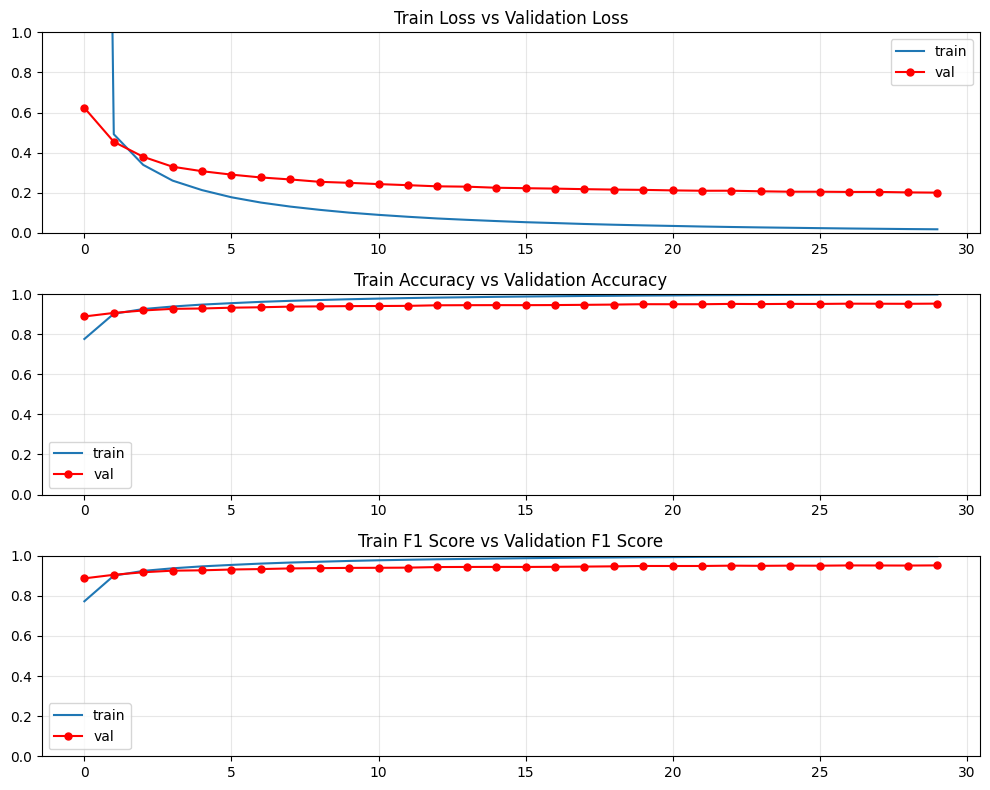

#####
case2 | Batch size: 32


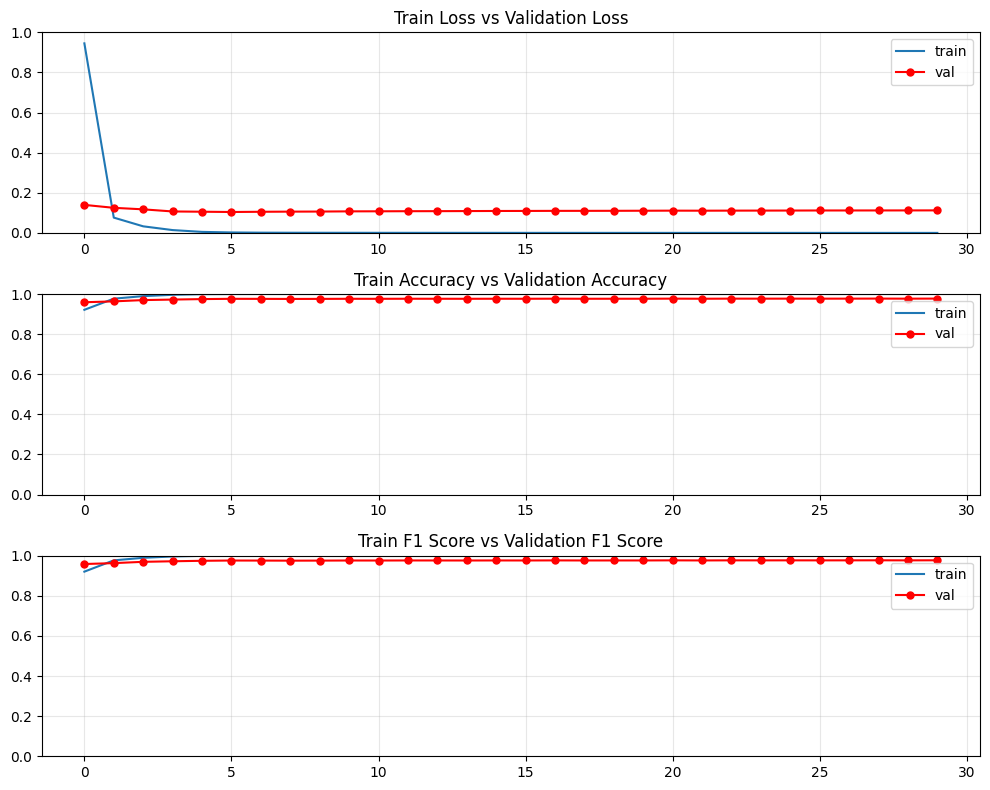

#####
case3 | Batch size: 1


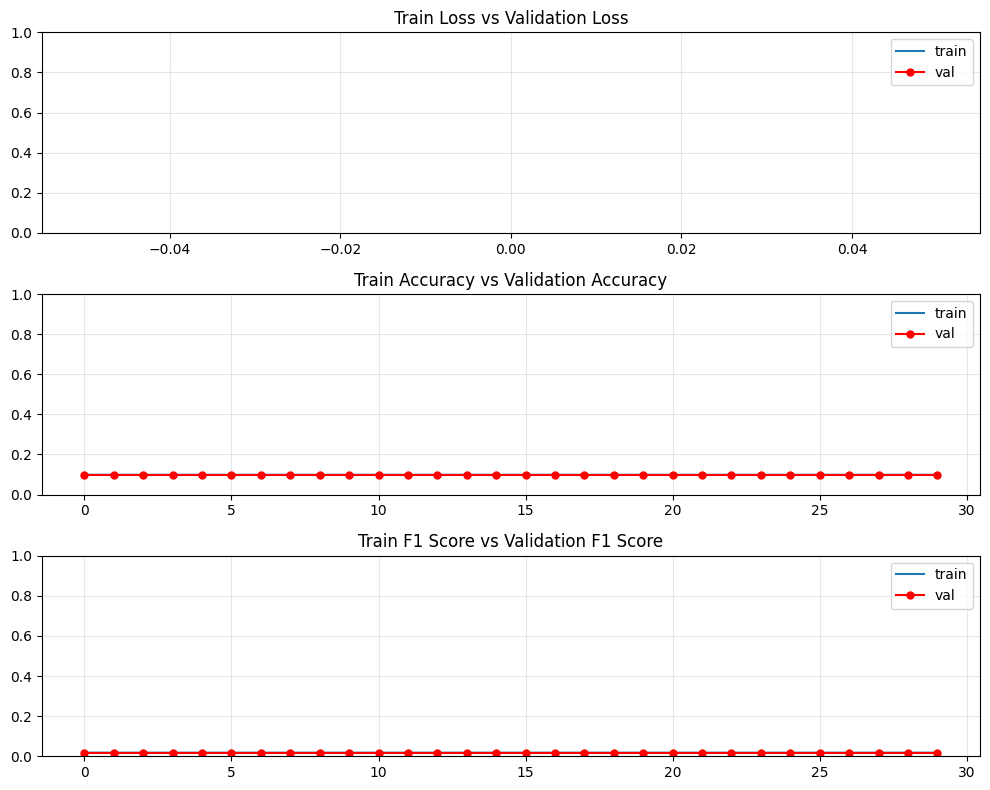

#####


In [10]:
import matplotlib.pyplot as plt

for case_name, config in experimental_config.items():
    # if case_name == "case3":
    #     continue

    val_metric_dict = config['val_metric_dict']
    train_metric_dict = config['train_metric_dict']
    batch_size = config['batch_size']

    print(f"{case_name} | Batch size: {batch_size}")
    plt.figure(figsize=(10, 8))

    # 1. Loss
    plt.subplot(3, 1, 1)
    plt.plot(range(len(train_metric_dict['loss'])), train_metric_dict['loss'], label='train')

    plt.plot(range(len(val_metric_dict['loss'])), val_metric_dict['loss'],
             linestyle='-', marker='o', markersize=5, color='red', label='val')
    plt.grid(alpha=0.3)
    plt.ylim(0.0, 1.0)
    plt.legend()
    plt.title("Train Loss vs Validation Loss")

    # 2. Accuracy
    plt.subplot(3, 1, 2)
    plt.plot(range(len(train_metric_dict['accuracy'])), train_metric_dict['accuracy'], label='train')

    plt.plot(range(len(val_metric_dict['accuracy'])), val_metric_dict['accuracy'],
             linestyle='-', marker='o', markersize=5, color='red', label='val')
    plt.grid(alpha=0.3)
    plt.ylim(0.0, 1.0)
    plt.legend()
    plt.title("Train Accuracy vs Validation Accuracy")

    # 3. F1 Score
    plt.subplot(3, 1, 3)
    plt.plot(range(len(train_metric_dict['f1_score'])), train_metric_dict['f1_score'], label='train')

    plt.plot(range(len(val_metric_dict['f1_score'])), val_metric_dict['f1_score'],
             linestyle='-', marker='o', markersize=5, color='red', label='val')
    plt.grid(alpha=0.3)
    plt.ylim(0.0, 1.0)
    plt.legend()
    plt.title("Train F1 Score vs Validation F1 Score")

    plt.tight_layout()
    plt.show()
    print("#####")


## 3.2 Test Metric

In [11]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

for case_name, config in experimental_config.items():
    print(f"[Test Evaluation] {case_name}")

    model = config['model']
    dataloader_dict = config['dataset']
    criterion = nn.CrossEntropyLoss()

    test_loss_lst = []
    test_preds_lst = []
    test_labels_lst = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader_dict['test']:
            inputs, labels = inputs.to(device), labels.to(device).long()
            preds = model(inputs)
            loss = criterion(preds, labels)

            preds_labels = torch.argmax(preds, dim=1).cpu().numpy()
            test_preds_lst.extend(preds_labels)
            test_labels_lst.extend(labels.cpu().numpy())
            test_loss_lst.append(loss.item())

    test_loss = np.mean(test_loss_lst)
    test_accuracy = accuracy_score(test_labels_lst, test_preds_lst)
    test_f1 = f1_score(test_labels_lst, test_preds_lst, average='macro')

    # 출력
    print(f"Test | Loss: {test_loss:.3f} | Accuracy: {test_accuracy:.3f} | F1_Score: {test_f1:.3f}\n")

    # 결과 저장 (선택 사항)
    config['test_metric'] = {
        'loss': test_loss,
        'accuracy': test_accuracy,
        'f1_score': test_f1
    }


[Test Evaluation] case1
Test | Loss: 0.254 | Accuracy: 0.951 | F1_Score: 0.950

[Test Evaluation] case2
Test | Loss: 0.150 | Accuracy: 0.967 | F1_Score: 0.967

[Test Evaluation] case3
Test | Loss: nan | Accuracy: 0.102 | F1_Score: 0.018



## 3.3 Case Confusion Matrix

[Confusion Matrix] case1


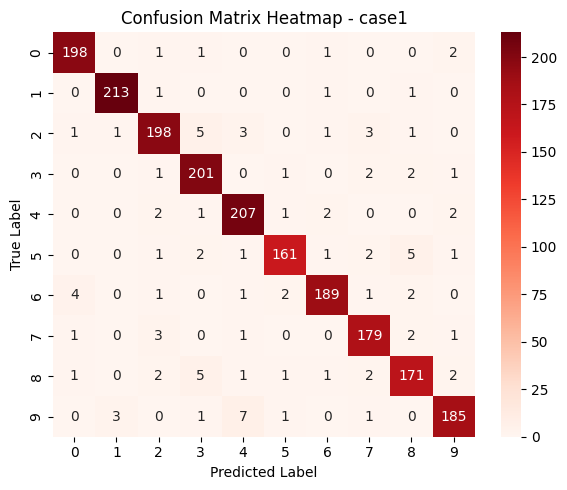

[Confusion Matrix] case2


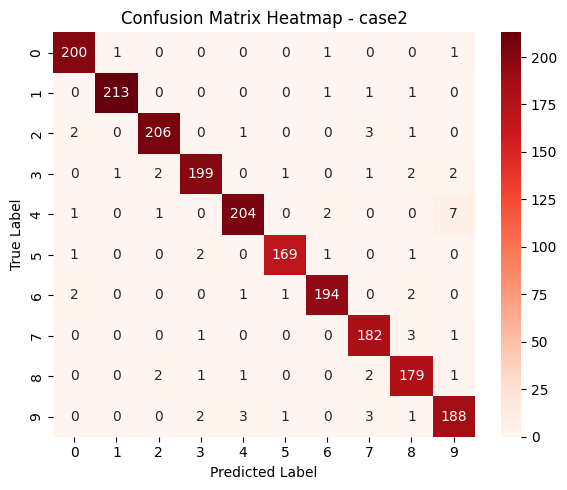

[Confusion Matrix] case3


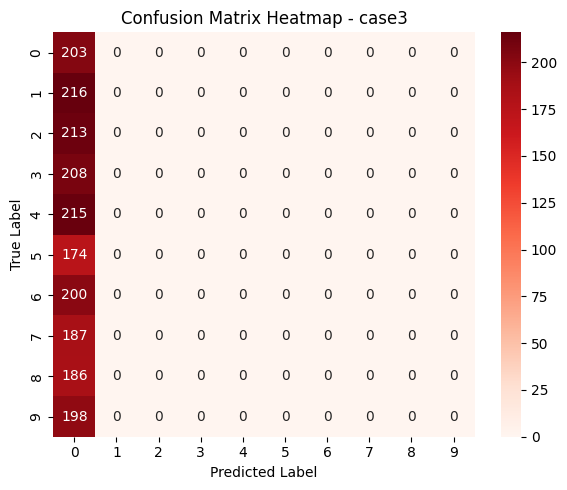

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

for case_name, config in experimental_config.items():
    print(f"[Confusion Matrix] {case_name}")

    model = config['model']
    dataloader_dict = config['dataset']
    criterion = nn.CrossEntropyLoss()

    test_preds_lst = []
    test_labels_lst = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader_dict['test']:
            inputs, labels = inputs.to(device), labels.to(device).long()
            preds = model(inputs)
            preds_labels = torch.argmax(preds, dim=1).cpu().numpy()
            test_preds_lst.extend(preds_labels)
            test_labels_lst.extend(labels.cpu().numpy())

    # Confusion matrix 생성
    matrix = confusion_matrix(test_labels_lst, test_preds_lst)

    # 시각화
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Reds", cbar=True,
                xticklabels=range(10), yticklabels=range(10))
    plt.title(f"Confusion Matrix Heatmap - {case_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()
